# sandbox.ipynb

This python notebook performs regressions on data pulled from a processed mongo DB created by GASpy. It then saves these regressions into pickles (for later use) and creates parity plots of the regression fits.

# Initialize

In [2]:
# Importing
import pdb
from gaspy_regress.regressor import GASpyRegressor
from gaspy_regress import gio, plot, predict
from gaspy.utils import vasp_settings_to_str, read_rc, docs_to_pdocs
from gaspy import defaults

VASP_SETTINGS = vasp_settings_to_str({'gga': 'RP',
                                      'pp_version': '5.4',
                                      'encut': 350})

# Regress

In [3]:
import copy
from tpot import TPOTRegressor

In [6]:
model_name = 'TPOT'
features = ['coordcount']
responses = ['energy']
blocks = ['adsorbate']

In [7]:
tpot = TPOTRegressor(
                     generations=2,
                     population_size=23,
                     verbosity=2,
                     random_state=42,
                    )
H = GASpyRegressor(features=features, responses=responses,
                   blocks=blocks, vasp_settings=VASP_SETTINGS,
                   fingerprints=fingerprints, train_size=0.8, dev_size=0.1)
fit_blocks = [('CO',), ('H',)]
H.fit_tpot(tpot, model_name=model_name, blocks=fit_blocks)

Version 0.9.1 of tpot is outdated. Version 0.9.2 was released Wednesday January 17, 2018.
Starting to pull documents...


/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/deap/creator.py:141: RuntimeWarning:

A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/deap/creator.py:141: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

42305it [00:01, 31196.54it/s]
Optimization Progress:  67%|██████▋   | 46/69 [01:16<00:23,  1.03s/pipeline]

Generation 1 - Current best internal CV score: 0.139417442442


Generation 2 - Current best internal CV score: 0.139417442442

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=15, n_estimators=100)


Optimization Progress:  67%|██████▋   | 46/69 [01:22<00:26,  1.17s/pipeline]

Generation 1 - Current best internal CV score: 0.143267009493


Generation 2 - Current best internal CV score: 0.143267009493

Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=39, p=2, weights=distance)


In [6]:
gio.dump_model(H)

In [10]:
H = gio.load_model(model_name, features+outer_features, responses, blocks)

RMSE values:
	('H',)
		test
			0.407478189987
		train
			0.167831735929
		all data
			0.388116693652
		dev
			0.40452419894
	('CO',)
		test
			0.362245655609
		train
			0.259714797869
		all data
			0.370040988306
		dev
			0.385430408266


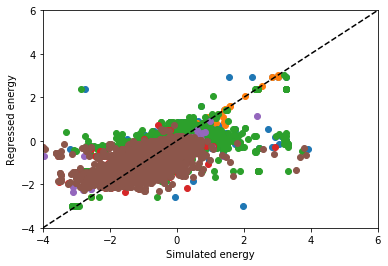

In [8]:
x, y, text = H.parity_plot(plotter='matplotlib', split=True)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict

In [ ]:
regressor = H
excel_file_path = read_rc()['gaspy_path'] + '/GASpy_regressions/volcanos_parsed.xlsx'

## CO$_2$ Reduction

In [29]:
regressor_block = ('CO',)
adsorbate = 'CO'
system = 'CO2RR'
scale = 'log'

In [ ]:
co2_data = predict.volcano(H, regressor_block, system, excel_file_path, scale, adsorbate)

In [ ]:
gio.dump_predictions(co2_data, regressor=H, system=system)

In [30]:
co2_data = gio.load_predictions(model_name, features+outer_features, responses, blocks, system)

NameError: name 'outer_features' is not defined

In [ ]:
plot.volcano(co2_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='plotly', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='hex', plot_range=[0.0001, 14],
                     save=True,
                     x_label='DFT-predicted activity [log(mA/cm2)]',
                     y_label='ML-estimated activity [log(mA/cm2)]',
                     title='Activity parity on surface minima')

## HER

In [ ]:
regressor_block = ('H',)
adsorbate = 'H'
system = 'HER'
scale = 'log'

In [ ]:
her_data = predict.volcano(H, regressor_block, system, excel_file_path, scale, adsorbate)

In [ ]:
gio.dump_predictions(her_data, regressor=H, system=system)

In [ ]:
her_data = gio.load_predictions(model_name, features+outer_features, responses, blocks, system)

In [ ]:
plot.volcano(her_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(her_data, scale=scale, plot_type='plotly', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [A/cm2]',
                     y_label='ML-estimated activity [A/cm2]',
                     title='Activity on surface minima')

In [ ]:
plot.filtered_parity(her_data, scale=scale, plot_type='hex', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [log(A/cm2)]',
                     y_label='ML-estimated activity [log(A/cm2)]',
                     title='Activity parity on surface minima')

# Database Visualization

## Elemental Grid Plot

In [ ]:
import pickle
import re
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

### Pull and process the data

In [ ]:
def parse(pkl):
    '''
    Open up a databall of predictions and process it into a form that's
    easier to visualize into a grid plot.

    Inputs:
        pkl             A string indicating the filename/location of the databall
        target_energy   The target adsorption energy
    Outputs:
        data            A list of tuples, where the first element in each tuple is a
                        list of the elements in a surface and the second element is
                        the minimum adsorption energy.
        unique_elements A set object containing the strings for each unique element
                        over the entire data set
    '''
    # Pull and pool the data for each surface
    with open(pkl, 'rb') as f:
        sim_results, unsim_results = pickle.load(f)
    results = sim_results + unsim_results

    # Initialize/create the `data` output
    data = []
    for result in results:
        # Parsing the data structure
        fingerprint = result[0]
        formula = fingerprint['formula']
        elements = re.findall('[A-Z][a-z]*', formula)
        elements = [ele for ele in elements if ele != 'C' and ele != 'O' and ele != 'U']
        # Filter out all alloys with more than 2 elements
        if len(elements) > 2:
            continue
        # More parsing and then information storage
        energy_data, _ = result[1]
        energy, _ = energy_data
        datum = (elements, energy)
        data.append(datum)

    # Identify the unique elements so we can loop through them
    unique_elements = set(element for datum in data for element in datum[0])

    return data, unique_elements

### Calculate performance

In [ ]:
def calc_performance(data, unique_elements, target_energy, ):
    '''
    We'll be plotting a performance matrix whose elements are between 0 and 1.
    A score of 1 is perfect, and a score of 0 indicates that you're... really bad.
    Note that we used a masked numpy array. Masked values indicate that we have
    neither DFT nor ML predictions for a particular alloy combination.
    
    Inputs:
        data
        
            %
                e
                    e
                        e
    Output:
        perf_matrix
    '''
    n_elements = len(unique_elements)
    perf_matrix = ma.masked_values(np.zeros((n_elements, n_elements)), 0)

    # Fill in the matrix on element at a time. We also make sure we don't investigate
    # an alloy twice, which would be double-dipping.
    investigated = []
    for i, el_i in enumerate(unique_elements):
        for j, el_j in enumerate(unique_elements):
            if set([el_i, el_j]) in investigated:
                continue
            investigated.append(set([el_i, el_j]))

            # Find the energies of all of the surfaces that match this alloy type
            energies = []
            # If it's an alloy...
            if el_i != el_j:
                for elements, energy in data:
                    if el_i in elements and el_j in elements:
                        energies.append(energy)
            # If it's monometallic...
            else:
                for elements, energy in data:
                    if el_i in elements and len(elements) == 1:
                        energies.append(energy)

            # Calculate and store the performance metric
            for energy in energies:
                performance = (1 - abs(energy-target_energy)/worst_energy_deviation) / len(energies)
                # Some fancy management because we're working with masked arrays
                if perf_matrix.mask[i, j]:
                    perf_matrix[i, j] = performance
                else:
                    perf_matrix[i, j] += performance
                    
    # Establish the target adsorption energy we want so that we can build a metric off of it
    target_energy = -0.6
    max_energy = max([datum[1] for datum in data])
    min_energy = min([datum[1] for datum in data])
    worst_dE_dev = max(abs(energy - target_energy)
                           for energy in (max_energy, min_energy))
    
    return perf_matrix

### Rank-ordering

In [ ]:
def rank(unique_elements, perf_matrix):
    '''
    Rank-order a matrix of performance values.
    
    Inputs:
        unique_elements     A set of strings containing all the unique elements
        perf_matrix         A numpy array containing the metrics of performance
                            for each alloy pairing. The index ording in this matrix
                            should be identical to the ordering in `unique_elements`
    Output:
        sorted_elements     A numpy array that has the same elements as
                            `unique_elements`, but ordered from best-to-last.
    '''
    # We can't order with sets, so turn `unique_elements` into a list
    unique_elements = list(unique_elements)

    # Calculate the average performance of each element. Since the perf_matrix
    # is diagonal, we do this by summing the matrix along both axes and then adding both
    # of the resulting vectors. We also have to take out the diagonal of the performance
    # matrix, because this method double-adds that element. And we divide by the counts
    # to get an average (which addresses holes of data).
    perf_vector = perf_matrix.sum(axis=0) + perf_matrix.sum(axis=1) - perf_matrix.diagonal()
    perf_vector = perf_vector / (perf_matrix.count(axis=0) + perf_matrix.count(axis=1) - 1)
    perf_vector = np.array(perf_vector)

    # Now sort
    sort_inds = perf_vector.argsort()[::-1]
    sorted_elements = np.array(unique_elements)[sort_inds]

    return sorted_elements

### Plotting

In [ ]:
def _plot_map(element_names, perf_matrix):
    '''
    Make a grid plot with a performance matrix and a set of corresponding
    keys
    
    Inputs:
        element_names   A sorted sequence whose elements are the corresponding
                        keys are the keys correspond to the elements in
                        `perf_matrix`
        perf_matrix     A 2-D numpy array containing the performance values
                        of various elemental pairings. The order in this matrix
                        needs to correspond to the order in `element_names`.
    '''
    # Make our own color scale between light gray and dark
    cmap = LinearSegmentedColormap.from_list(name='bluescale',
                                             colors=['lightgray', 'black'],
                                             N=100)
    # Initialize the plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    # Plot the matrix
    cax = ax.matshow(perf_matrix, cmap=cmap)
    # Create a colorbar
    #cb = fig.colorbar(cax)
    # Label the axes
    ax.set_xticklabels([''] + list(element_names))
    ax.set_yticklabels([''] + list(element_names))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Wrap it all up

In [ ]:
def plot_map(pkl, target_energy):
    '''
    Wrapper function that creates a grid plot from a pickle name and a target energy.
    
    Inputs:
        pkl             A string indicating the filename/location of the databall
        target_energy   The adsorption energy that you're targeting (eV)
    Outputs:
        sorted_elements     A numpy array that contains all of the elements
                            in the databall, but ordered from best-to-worst
        perf_matrix         A numpy array of the performance matrix of each
                            alloy. The index ordering corresponds to the one
                            in `sorted_elements`.
    '''
    # Parse the databall
    data, unique_elements, worst_energy_deviation = parse(pkl, target_energy)
    # Calculate the performance of each alloy set, and then use that performance
    # to rank-order the single elements.
    perf_matrix = calc_performance(data, unique_elements,
                                   target_energy, worst_energy_deviation)
    sorted_elements = rank(unique_elements, perf_matrix)
    # Re-calculate performance with the new rank order. We are doing extra
    # work here at the cost of ease-of-coding. You may fix this if you want.
    perf_matrix = calc_performance(data, sorted_elements,
                                   target_energy, worst_energy_deviation)
    # Plot and return 
    _plot_map(sorted_elements, perf_matrix)
    return sorted_elements, perf_matrix

### CO

In [ ]:
co_pkl = 'pkls/CO2RR_predictions_GP_around_TPOT_FEATURES_coordcount_neighbors_coordcounts_RESPONSES_energy_BLOCKS_adsorbate.pkl'
co_target_energy = -0.6
co_rankings, co_perfs = plot_map(co_pkl, co_target_energy)

### H

In [ ]:
h_pkl = 'pkls/HER_predictions_GP_around_TPOT_FEATURES_coordcount_neighbors_coordcounts_RESPONSES_energy_BLOCKS_adsorbate.pkl'
h_target_energy = -0.27
her_rankings, her_perfs = plot_map(h_pkl, h_target_energy)